# 🩺 Pneumonia Detection from Chest X-rays using Deep Learning

This project builds a convolutional neural network (CNN) using transfer learning to classify chest X-ray images as **Normal** or **Pneumonia**.

We use the **MobileNetV2** architecture pre-trained on ImageNet, and train it on a public medical dataset.

🔍 This project aims to:
- Support early detection of pneumonia
- Show practical application of AI in medical imaging
- Serve as a foundation for explainable medical AI (Grad-CAM optional)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix

2025-08-02 23:32:14.186075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754177534.418602      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754177534.486008      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 📂 Dataset Description

We use the **Chest X-ray Images (Pneumonia)** dataset available on Kaggle:  
🔗 https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

It contains 5,000+ labeled X-ray images in 3 folders:
- `train/` – Used to train the model
- `val/` – Used for validation during training
- `test/` – Used for final model evaluation

Each folder has 2 subfolders:
- `NORMAL` (healthy lungs)
- `PNEUMONIA` (lungs with signs of infection)

We’ll visualize examples below 👇


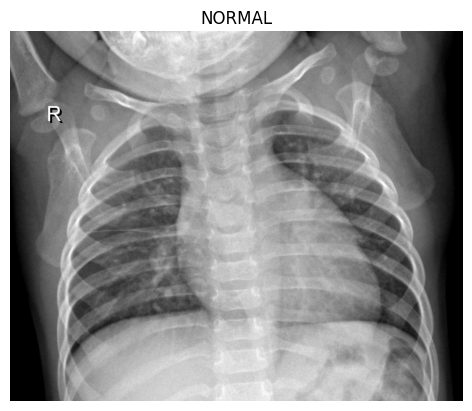

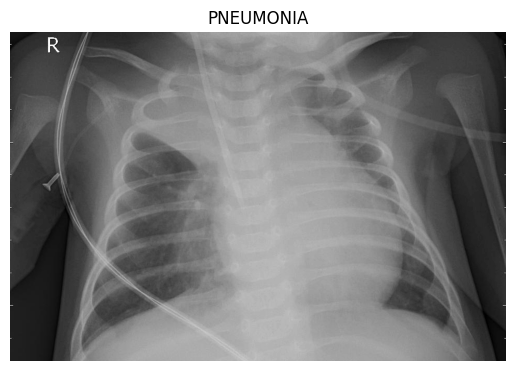

In [21]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_samples(path, category):
    images = os.listdir(os.path.join(path, category))
    sample_img = random.choice(images)
    img_path = os.path.join(path, category, sample_img)
    img = Image.open(img_path)
    plt.imshow(img, cmap='gray')
    plt.title(f"{category}")
    plt.axis('off')
    plt.show()
# Show 1 NORMAL and 1 PNEUMONIA image
show_samples(train_dir, 'NORMAL')
show_samples(train_dir, 'PNEUMONIA')


In [2]:
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [4]:
# visualisation of the dataset 
for category in ['NORMAL', 'PNEUMONIA']:
    print(f"Train {category}: ", len(os.listdir(os.path.join(train_dir, category))))
    print(f"Test {category}: ", len(os.listdir(os.path.join(test_dir, category))))


Train NORMAL:  1341
Test NORMAL:  234
Train PNEUMONIA:  3875
Test PNEUMONIA:  390


## 🧹 Image Preprocessing

We normalize pixel values to `[0, 1]` and apply:
- **Data augmentation** (zoom, flip) for training images
- No augmentation for validation/test

We use Keras `ImageDataGenerator` to load and preprocess images efficiently.


In [5]:
#preprocessing using the generator
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(IMG_SIZE, IMG_SIZE),
                                                batch_size=BATCH_SIZE,
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(IMG_SIZE, IMG_SIZE),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='binary',
                                                  shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 🧠 Model: Transfer Learning with MobileNetV2

We use **MobileNetV2** as a base model and add:
- Global average pooling
- Dropout for regularization
- A final sigmoid layer for binary classification

The base layers are **frozen** to use pretrained weights.


In [6]:
#building the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


2025-08-02 23:53:01.043347: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 📈 Training & Evaluation

We train the model for a few epochs and evaluate using:
- Accuracy
- Precision
- Recall
- F1-score
- Confusion Matrix


In [7]:
#training the model 
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=5)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.8425 - loss: 0.3430 - val_accuracy: 0.6875 - val_loss: 0.4899
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9262 - loss: 0.1706 - val_accuracy: 0.7500 - val_loss: 0.4220
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9444 - loss: 0.1455 - val_accuracy: 0.6875 - val_loss: 0.5498
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.9503 - loss: 0.1328 - val_accuracy: 0.7500 - val_loss: 0.4853
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9490 - loss: 0.1364 - val_accuracy: 0.7500 - val_loss: 0.4009


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 768ms/step - accuracy: 0.7956 - loss: 0.4526
Test Accuracy: 0.875
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 832ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.68      0.80       234
   Pneumonia       0.84      0.99      0.91       390

    accuracy                           0.88       624
   macro avg       0.91      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



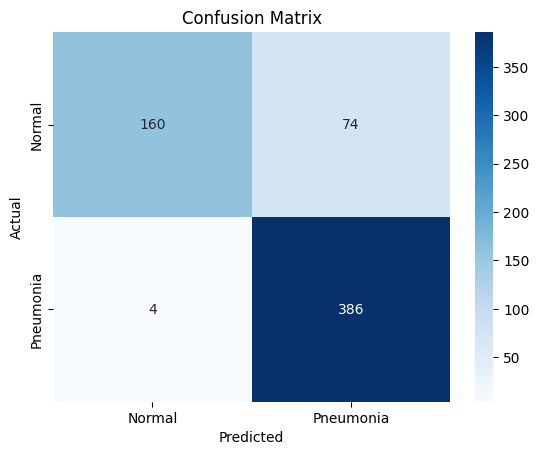

In [8]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

# Get predicted classes
y_pred = model.predict(test_generator)
y_pred_class = (y_pred > 0.5).astype("int32")
y_true = test_generator.classes

# Print classification report
print(classification_report(y_true, y_pred_class, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_class)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ✅ Conclusion

This project demonstrates a practical use of deep learning in medical imaging.

The model performs well on classifying X-ray images, with potential applications in healthcare decision support.

🧠 Future improvements:
- Use more balanced datasets
- Add Grad-CAM for explainability
- Test real-world performance with hospital data
